In [1]:
###############################################
## Import necessary libraries and files
###############################################
import numpy as cp
try:
    import cupy
    if cupy.cuda.is_available():
        cp = cupy
except:
    pass
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import time
import sys
from rbm import RBM
from aux import binarize_data
from aux import get_dataset
from aux import load_files
from aux import plot_funcs

In [2]:
###############################################
## Control Panel
###############################################

# hyperparameters of the RBM

model = {
    'N':784,                  # number of visible units
    'M':100,                  # number of hidden units
    'eta':0.1,                # learning rate of the RBM
    'batch_size':100,         # batch size
    'W_init':'lecun'          #{'lecun', 'std'} --weight initialization
}

training_settings = {
'dataset': 'mnist',            #{'mnist','kmnist'} --dataset
'KH': 'top-down',              #{None, 'top-down', 'bottom-up'} --KH Modulation approach
'training': 'CD',              #{'CD', 'PCD'} --training algorithm of the RBM
'k': 1,                        # number of Gibbs sampling steps
'epochs': 3,                   # number of epochs (S)
'eps0': 4e-2,                  # KH learning rate
'eps_d': True,                 #{False, True} -- decays with a polynomial eps0*(1- t/epochs)^(3/2)
'delta': 0.4,                  # KH penalty term
'p': 2.0,                      # KH Lebesgue power
'l': 2,                        # KH ranking parameter l >= 2
'R': 1.0 if model['W_init'] == 'std' else 0.1, # Lebesgue p norm radius
'seed': 1234,                  # random seed
'addrss': '', #'out/'
'label': 'p1.5decay'
}

In [3]:
###############################################
## Loading and preprocessing dataset
###############################################

train_data, valid_data, test_data, train_labels, valid_labels, test_labels = get_dataset(dataset=training_settings['dataset'])

try:
    if cp == cupy:
        train_data = cp.asarray(train_data)
        valid_data = cp.asarray(valid_data)
        test_data = cp.asarray(test_data)
except:
    pass

train_data = cp.concatenate((train_data,valid_data))

# data binarization
X_train = binarize_data(train_data)
X_test = binarize_data(test_data)

2024-09-10 18:19:07.622863: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-10 18:19:09.514880: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2024-09-10 18:19:09.620772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2024-09-10 18:19:09.621235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start abo

Training Images Shape: (50000, 784)
Training Labels Shape: (50000, 10)
Validation Images Shape: (10000, 784)
Validation Labels Shape: (10000, 10)
Test Images Shape: (10000, 784)
Test Labels Shape: (10000, 10)


Epoch 1/3, Training Data Reconstructions:


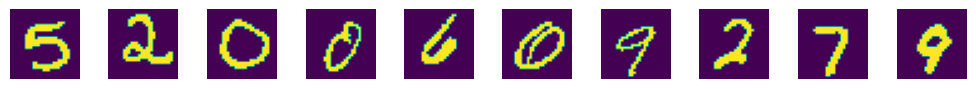

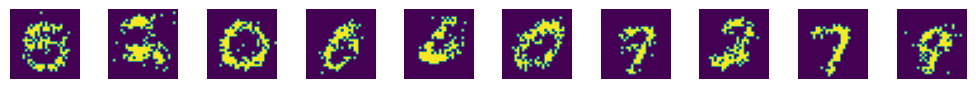

Epoch 1/3, Training MSE: 87.4972333
Epoch 1/3, Validation MSE: 69.0097000
Epoch 1/3, Validation Data Reconstructions:


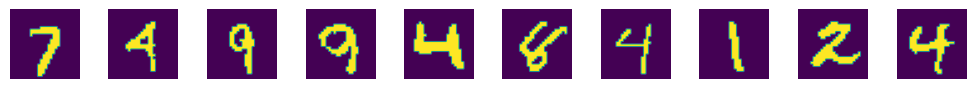

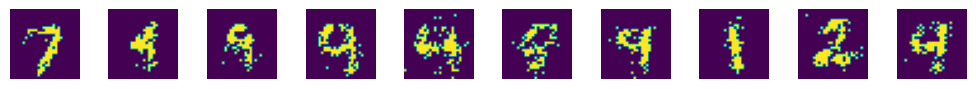

Receptive Fields:


<Figure size 640x480 with 0 Axes>

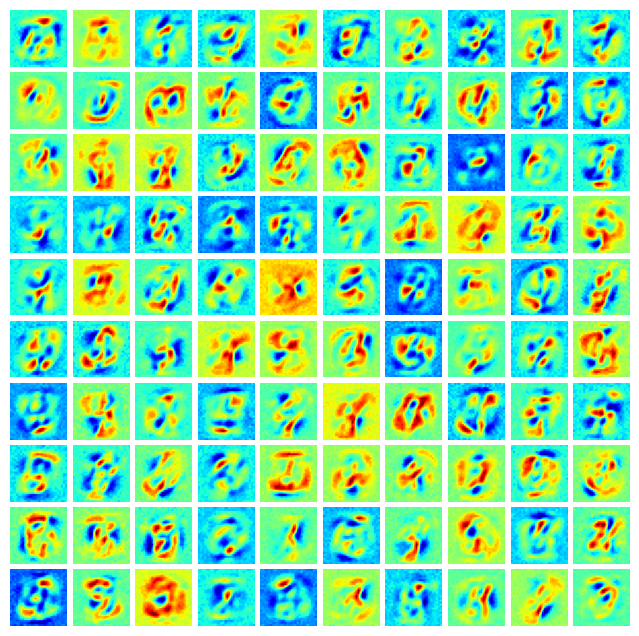

Epoch 2/3, Training Data Reconstructions:


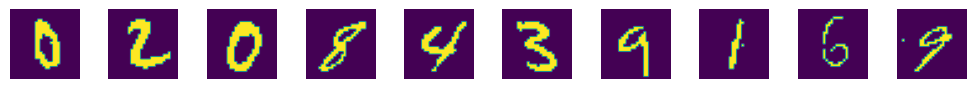

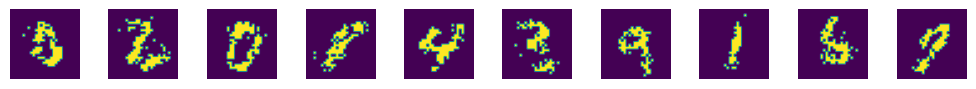

Epoch 2/3, Training MSE: 64.0748000
Epoch 2/3, Validation MSE: 60.6348000
Epoch 2/3, Validation Data Reconstructions:


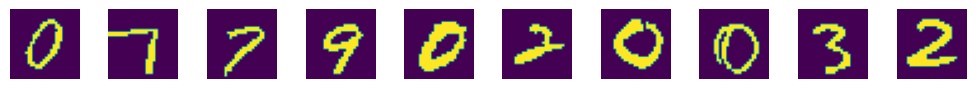

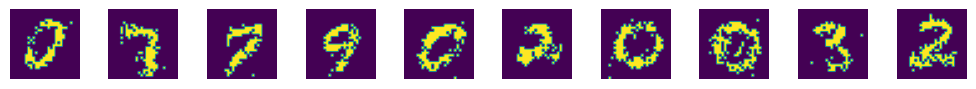

Receptive Fields:


<Figure size 640x480 with 0 Axes>

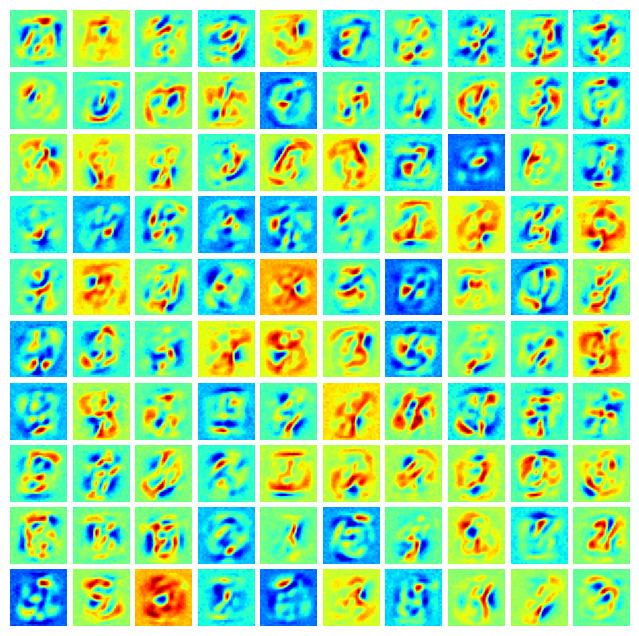

Epoch 3/3, Training Data Reconstructions:


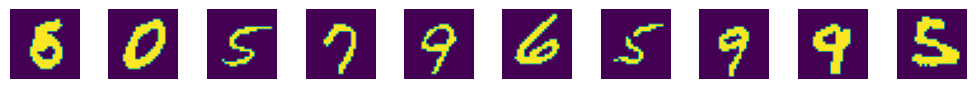

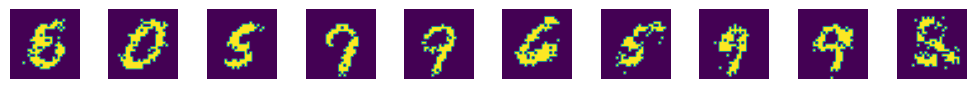

Epoch 3/3, Training MSE: 58.0032333
Epoch 3/3, Validation MSE: 56.0847000
Epoch 3/3, Validation Data Reconstructions:


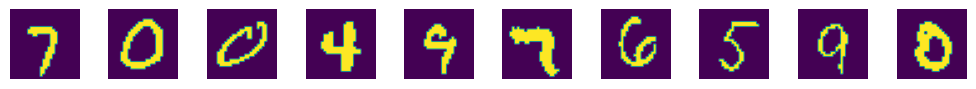

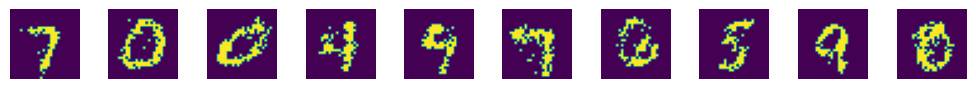

Receptive Fields:


<Figure size 640x480 with 0 Axes>

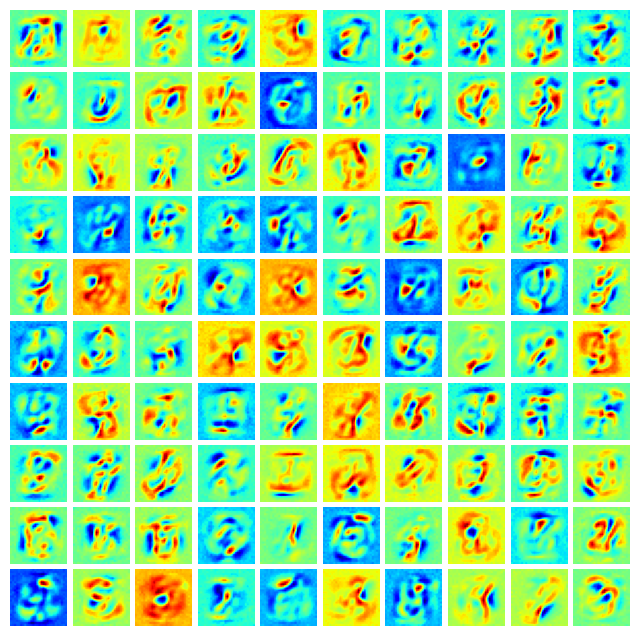

Total training time: 46.57 seconds


In [4]:
start_time = time.time()
cp.random.seed(seed=training_settings['seed'])
rbm = RBM(model)
rbm.train(X_train,X_test,training_settings,incr=1,save_checkpoints=False,track_learning=True,save_learn_funcs=True,
          save_params=True,plot_weights=True)
end_time = time.time()  # Record the end time for the entire training process
total_training_time = end_time - start_time
print('Total training time: %.2f seconds' % total_training_time)

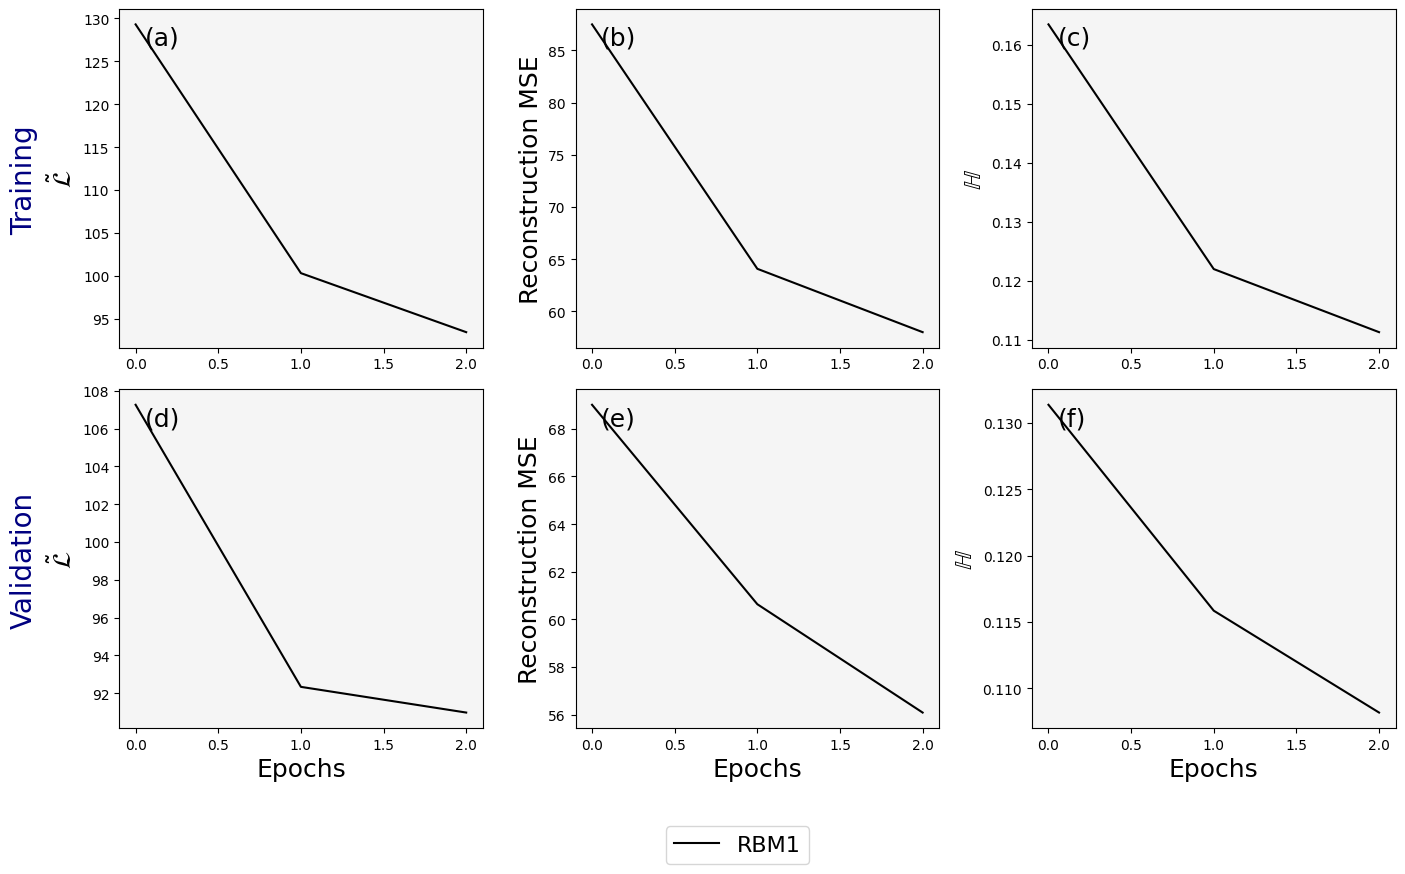

In [6]:
models = [model]
settings = [training_settings]
r_tr = [] 
r_vl = []
for i in range(len(models)):
    r_tr.append(load_files(models[i],settings[i],d_name='_tr'))
    r_vl.append(load_files(models[i],settings[i],d_name='_val'))

limits = [[(200,501,140,160),(300,501,85,95),(300, 501, 0.168, 0.19)],
          [(300,501,155,174),(300,501,90,100),(300, 501, 0.182, 0.205)]]

inp_label = ['RBM1']
plot_funcs(r_tr,inp_label,r_vl,limits,sc='l',inset=False,save=False,name='')

In [5]:
import json

# Load the hyperparameters for a given model
task = 'reconst'
dataset = 'mnist'    #{'mnist','kmnist'}
M = 100              #{100,500}
W_init = 'lecun'     #{'lecun','std'}
KH = 'top-down'      #{'top-down','bottom-up',None} where None refers to shallow RBM

dict_name = task+'_'+dataset+'_'+str(M)+'_'+W_init+'_'+KH
print(dict_name)

# Load the JSON file that contains hyperparameters
with open("configs/"+dict_name+".json", "r") as f:
    data = json.load(f)

# Access each dictionary
model = data["model"]
training_settings = data["training_settings"]

# Print to verify
print("model:", model)
print()
print("trainig_settings:", training_settings)

reconst_mnist_100_lecun_top-down
model: {'N': 784, 'M': 100, 'eta': 0.1, 'batch_size': 100, 'W_init': 'lecun'}

trainig_settings: {'dataset': 'mnist', 'KH': 'top-down', 'training': 'CD', 'k': 1, 'epochs': 500, 'eps0': 0.04, 'eps_d': True, 'delta': 0.4, 'p': 2.0, 'l': 2, 'R': 0.1, 'seed': 1234, 'addrss': '', 'label': 'p1.5decay'}


In [7]:
# You may change the hyperparameters or settings by calling the related dictionary keyword, e.g
training_settings['k'] = 10 
training_settings['epochs'] = 3

# Print to verify
print("model:", model)
print()
print("trainig_settings:", training_settings)

model: {'N': 784, 'M': 100, 'eta': 0.1, 'batch_size': 100, 'W_init': 'lecun'}

trainig_settings: {'dataset': 'mnist', 'KH': 'top-down', 'training': 'CD', 'k': 10, 'epochs': 3, 'eps0': 0.04, 'eps_d': True, 'delta': 0.4, 'p': 2.0, 'l': 2, 'R': 0.1, 'seed': 1234, 'addrss': '', 'label': 'p1.5decay'}
